In [3]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import json,os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
# sentiment analysis 

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import re
from wordcloud import WordCloud, STOPWORDS
os.chdir("D:\CSP 571\yelp data")
business = pd.read_json('business.json', lines=True)

### First we will chek the columns of the business data

In [4]:
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [5]:
business.categories

0                                         Golf, Active Life
1         Specialty Food, Restaurants, Dim Sum, Imported...
2                         Sushi Bars, Restaurants, Japanese
3                             Insurance, Financial Services
4         Plumbing, Shopping, Local Services, Home Servi...
                                ...                        
192604    Water Purification Services, Water Heater Inst...
192605                 Books, Mags, Music & Video, Shopping
192606    Home Services, Contractors, Landscaping, Mason...
192607                               Beauty & Spas, Barbers
192608                               Massage, Beauty & Spas
Name: categories, Length: 192609, dtype: object

### Business data consists of information based on a lot of categories such as Golf, Insurance, etc. but a single business can be categorized in multiple ways. Therefore, we shall split the categories in the "Category" column

In [6]:
business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
cat = business.categories.value_counts()

In [7]:
cat = cat.to_frame().reset_index()

In [8]:
cat.columns = ['Categories', 'Count']
cat

,Categories,Count
0,Restaurants,59371
1,Shopping,31878
2,Food,29989
3,Home Services,19729
4,Beauty & Spas,19370
...,...,...
1295,General Festivals,1
1296,Toxicologists,1
1297,Rotisserie Chicken,1
1298,Czech/Slovakian,1


### There are 1300 categories. We shall check top 10 categories.

In [9]:
cat= cat.sort_values(by = 'Count', ascending = False)

In [10]:
cat = cat[0:10]

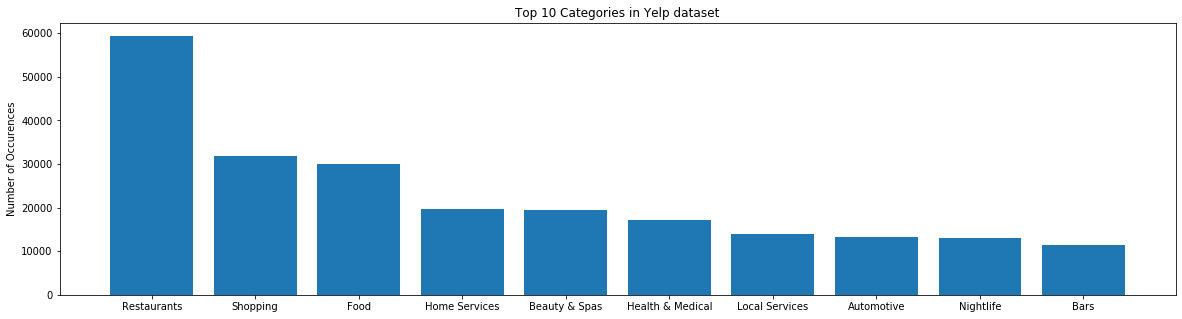

In [11]:
objects = list(cat.Categories)
y_pos = np.arange(len(objects))
Numbers = list(cat.Count)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Occurences')
plt.title('Top 10 Categories in Yelp dataset')
plt.show()

### These are the top 10 categories in this data. But for our analysis, we shall focus more on business which comes in restaurant category. 

In [12]:
# business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
# count = business.categories.value_counts().tolist()
# res_cat = business.categories.tolist()
# res_cat = list(set(res_cat))

In [13]:
# count = business.categories.value_counts().tolist()
# categories_list = business.categories.str.split().tolist()
# categories_list

In [14]:
# business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
business = business[business.categories.str.contains('Restaurants', case=True,na=False)]
business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...",Restaurants,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",Restaurants,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0,18,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",Restaurants,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W..."
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0,16,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",Restaurants,"{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",Restaurants,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192587,oS0CnUbyv0GUoD3L8_3UPQ,Thai Fantasy,578 Yonge Street,Toronto,ON,M4Y 1Z3,43.665120,-79.384809,4.0,113,1,"{'RestaurantsPriceRange2': '2', 'RestaurantsGo...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-23:0', ..."
192589,ghovD5ZTGDQ5Q2U4ERddWw,Five Guys,3863 Medina Rd,Fairlawn,OH,44333,41.136561,-81.639712,4.0,22,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'Fals...",Restaurants,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
192595,h3QErqS3OZgLJ5Tb6-sLyQ,Asia Hut,1450 Kingston Rd,Pickering,ON,L1V 1C1,43.841844,-79.083881,4.5,4,1,"{'BikeParking': 'True', 'RestaurantsAttire': '...",Restaurants,"{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
192596,KnafX7T6qSAmSrLhd709vA,Pho Maisonneuve,948 Boulevard de Maisonneuve Est,MontrÃ©al,QC,H2L 1Z1,45.517430,-73.558873,4.0,25,1,"{'GoodForKids': 'True', 'WiFi': 'u'no'', 'Rest...",Restaurants,"{'Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'..."


### We only need to focus on the restaurants which are open ( i.e. business.is_open ==1) 

In [15]:
# Taking into the consideration the businesses which are open
# 1 = open, 0 = closed
business = business[business['is_open']==1]

## Taking average into consideration for all the US states

In [16]:
# taking into consideration US states only

states = pd.Series(["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"])

In [17]:
avg_stars = pd.pivot_table(business[business['state'].isin(states)] , index = ['state'], 
                    values = ['stars'], aggfunc = np.mean)

avg_stars=avg_stars.sort_values('stars',ascending=False)

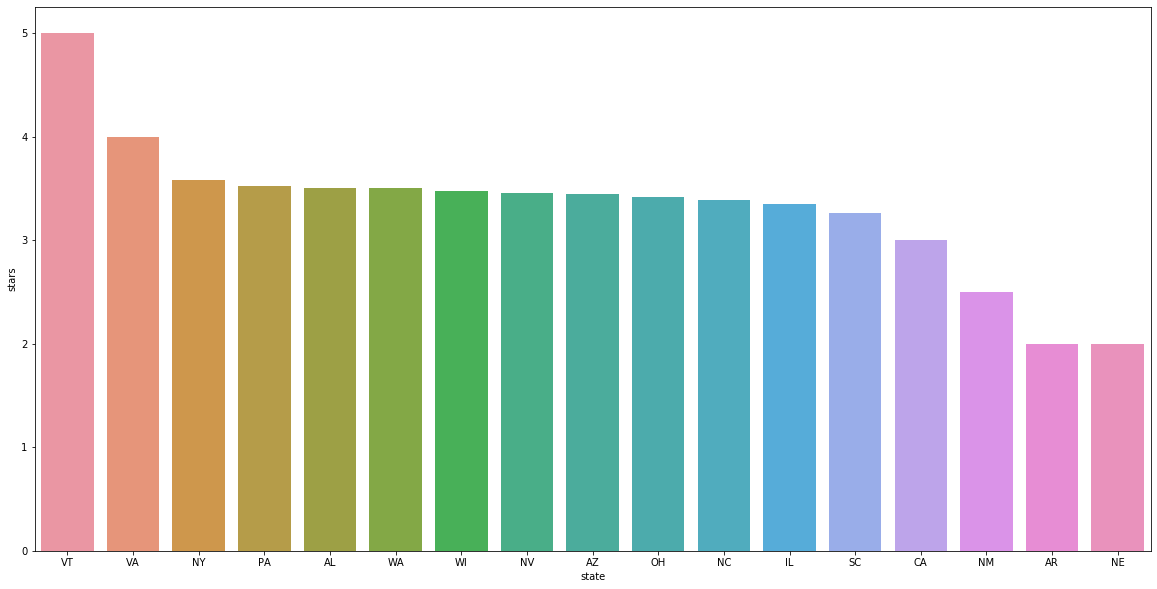

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
a = sns.barplot(x=avg_stars.index, y="stars", data=avg_stars)

### Now we shall see the distribution of state in this dataset

In [19]:
state_count = business.state.value_counts()

In [20]:
state_count = state_count.to_frame().reset_index()
state_count.columns = ['State', 'Counts']

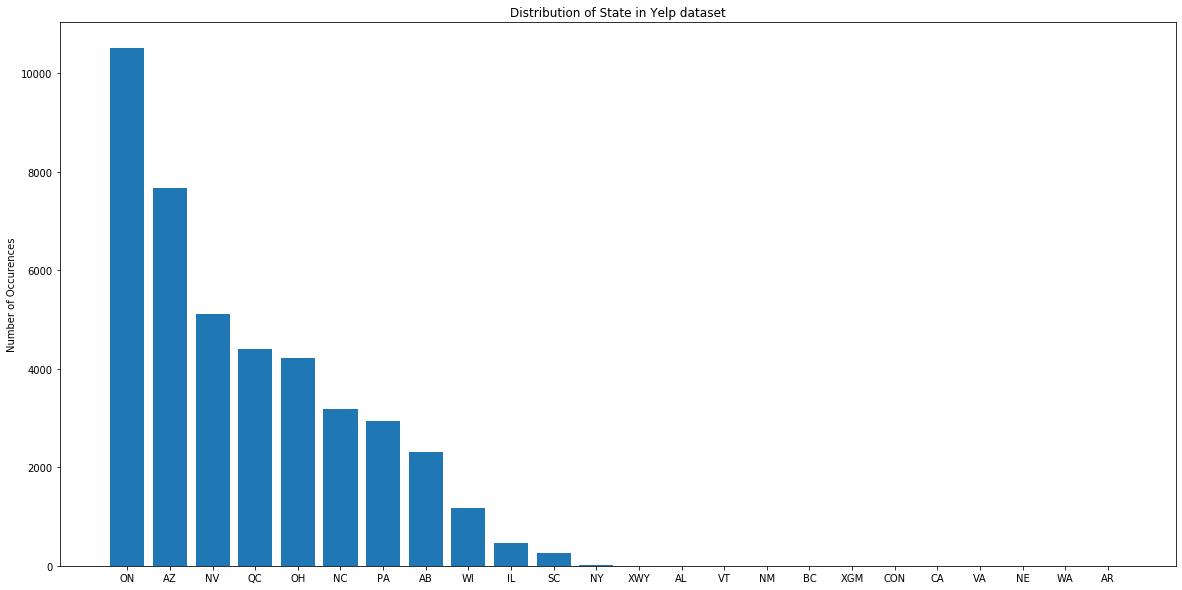

In [21]:
objects = list(state_count.State)
y_pos = np.arange(len(objects))
Numbers = list(state_count.Counts)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Occurences')
plt.title('Distribution of State in Yelp dataset')
plt.show()



### From this, graph, we see the statewise distribution of restaurants. As we can see, this data consists of restaurants present all over the world. For the sake of simplicity, we will focus on the restaurants present in Illinois.

In [22]:
business_in_IL = business[business.state == 'IL']

In [23]:
business_in_IL = business_in_IL.reset_index(drop = True)

In [24]:
business_in_IL

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,713 W Marketview Dr,Champaign,IL,61822,40.137270,-88.256043,2.5,72,1,"{'WiFi': 'u'no'', 'RestaurantsReservations': '...",Restaurants,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
1,m4DwPVxmFDQE_FnGIOa3cQ,Sunny China Buffet,1703 Philo Rd,Urbana,IL,61802,40.097639,-88.191217,3.5,15,1,"{'RestaurantsGoodForGroups': 'True', 'Business...",Restaurants,None
2,HbK6IfznbVToEaKVC0WcSg,The Clark Bar,207 W Clark St,Champaign,IL,61820,40.115017,-88.246156,3.5,24,1,"{'Alcohol': 'u'full_bar'', 'GoodForKids': 'Fal...",Restaurants,"{'Tuesday': '16:0-2:0', 'Wednesday': '16:0-2:0..."
3,o9nGD3J0btXjE9M6IdgZTA,McAlister's Deli,421 Town Center Rd,Champaign,IL,61820,40.141668,-88.250360,3.0,50,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '10:30-21:0',..."
4,sDfN5qJlmvrwTfwEPBsxSg,Dairy Queen,1103 Klein Ave,Rantoul,IL,61866,40.311299,-88.142882,2.0,4,1,"{'GoodForKids': 'False', 'BusinessAcceptsCredi...",Restaurants,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,nD4cF5IH8RE7LFGdR2FMUA,Windy City Express,410 N Race St,Urbana,IL,61801,40.116172,-88.208663,3.5,28,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'n...",Restaurants,None
453,zTGxLMOd9crAz0XNzqrcrA,Empire Chinese Restaurant,"410 E Green St, Ste 1",Champaign,IL,61820,40.110638,-88.232483,3.5,48,1,"{'BusinessAcceptsCreditCards': 'True', 'BYOBCo...",Restaurants,"{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3..."
454,0QgFIP9W0eGZSxCSQRQSCg,Subway,"701 S Gregory St, Ste A",Urbana,IL,61801,40.106711,-88.221752,2.5,6,1,"{'RestaurantsDelivery': 'False', 'RestaurantsR...",Restaurants,None
455,gZtJyb2oEpwo1rnovDVPfA,Intermezzo CafÃ©,500 S Goodwin Ave,Urbana,IL,61801,40.108000,-88.222501,3.5,11,1,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...",Restaurants,"{'Monday': '7:30-15:30', 'Tuesday': '7:30-15:3..."


In [25]:
business_in_IL.to_csv("Business_in_Illinois.csv")

In [28]:

# city_il = business_in_IL.city.value_counts()
# city_il = city_il.to_frame().reset_index()
# city['latitude'] = business_in_IL[]
# city_il.columns = ['City', 'Counts']

fig = px.scatter_mapbox(business_in_IL, lat="latitude", lon="longitude", hover_name="city", color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [29]:
city_il = business_in_IL.city.value_counts()
city_il = city_il.to_frame().reset_index()
city_il.columns = ['City', 'Counts']
# labels = list(city_il.City)
# sizes = list(city_il.Counts)
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111)
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# plt.axis('equal')
# plt.show()

In [30]:
### Focusing on the stars achieved by the businesses


In [31]:
# #Get the distribution of the ratings
# x=business['stars'].value_counts()
# x=x.sort_index()
# #plot
# plt.figure(figsize=(8,4))
# ax= sns.barplot(x.index, x.values, alpha=0.8)
# plt.title("Star Rating Distribution")
# plt.ylabel('# of businesses', fontsize=12)
# plt.xlabel('Star Ratings ', fontsize=12)

# #adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

# plt.show()

###  Distribuiton of restaurant business in Illinois

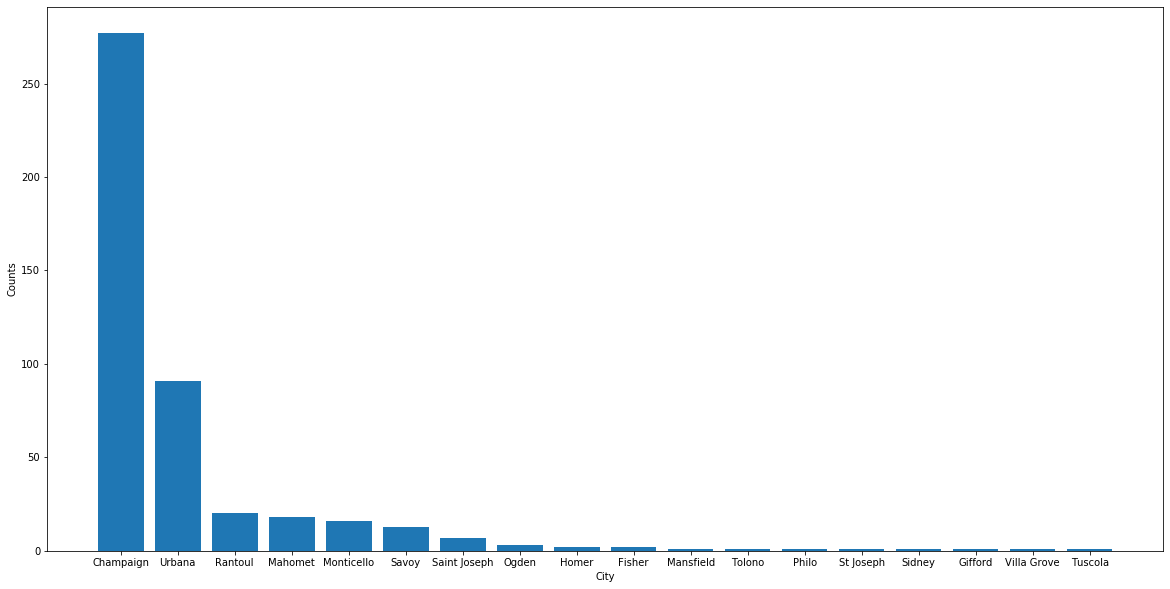

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(city_il.City, city_il.Counts, align = 'center', alpha = 1)
plt.xlabel("City")
plt.ylabel("Counts")
plt.show()

### Now we will check which all Restaurants got 5-star ratings and how much

In [33]:
reviews = []
with open(os.path.join(os.getcwd(), 'review.json'),encoding="utf8") as f:
    for line in f:
        reviews.append(json.loads(line))

In [34]:
reviews = pd.DataFrame(reviews)

In [35]:
business_ratings = pd.merge(business_in_IL, reviews[['review_id', 'business_id', 'stars']], on = 'business_id', how = 'left')

In [36]:
Five_star = business_ratings[business_ratings['stars_y'] == 5.0]

In [37]:
Five_star_order = Five_star.name.value_counts()

In [38]:
Five_star_order = Five_star_order.to_frame().reset_index()
Five_star_order.columns = ['Restaurant', 'Counts']


In [41]:
Five_star_order = Five_star_order.head(10)
Five_star_order = Five_star_order.sort_values(['Counts'], ascending = True)
Five_star_order

,Restaurant,Counts
9,Huaraches Moroleon,121
8,Courier Cafe,126
7,Seven Saints,127
6,Farren's Pub & Eatery,128
5,Papa Del's Pizza,141
4,Sakanaya,232
3,DESTIHL Restaurant & Brew Works,243
2,Golden Harbor Authentic Chinese Cuisine,246
1,Maize Mexican Grill,350
0,Black Dog Smoke & Ale House,668


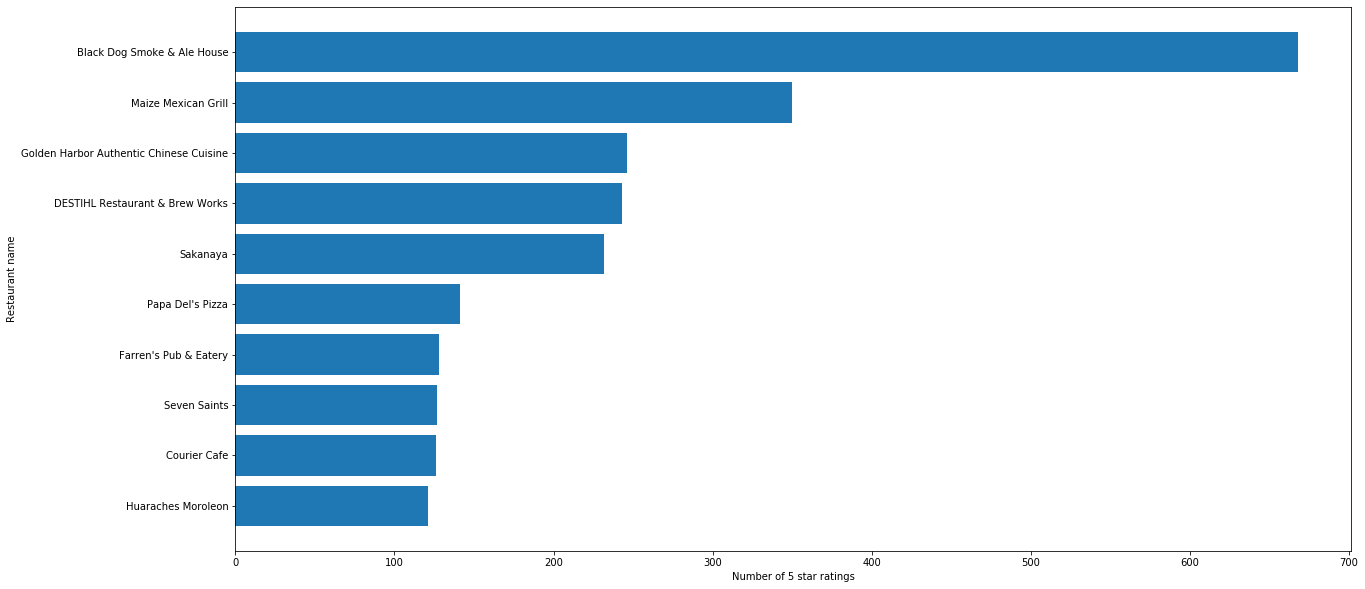

In [42]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
plt.barh(Five_star_order.Restaurant, Five_star_order.Counts, align = 'center', alpha = 1)
plt.ylabel('Restaurant name')
plt.xlabel('Number of 5 star ratings')
plt.show()

### We can deduce  Black Dog Smoke & Ale House got the highest amount of 5-star ratings.

In [43]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [44]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shouv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
ids = business_in_IL.business_id.to_list()

In [46]:
review_IL = reviews[reviews.business_id.isin(ids)]
review_IL

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
746,TfJ2QlHY7sFdPpUyDi27Zg,c_vQnScwjEmPflK9ntnwmw,zswdqM8Av3KxVv9o7_6ORA,4.0,0,0,0,Everything was pretty good but the beef in the...,2017-07-08 17:24:58
973,ilkuxI6oH3s1dEYW_Kxysw,_oxSgMz5Ryfs0NQFqy56Cw,SgG5E7PUrCIsEMP0BVSlTg,5.0,10,0,2,Very pleased with everything I've bought here:...,2013-10-03 11:36:25
1421,X81JNJJg75edpHgT5nb7xw,9qAt7wTgl6mYtxPGZGwyWw,yRKrMWQxQaMeR18s5ajcYw,1.0,0,0,0,Nothing like paying $10+ for a container of cu...,2017-07-18 17:53:48
1492,qChAyy6hNJ4UmEk9XCCPAw,u7UaLSwFyxVOjD8n6V4ROA,SgG5E7PUrCIsEMP0BVSlTg,4.0,6,2,2,Modified my previous review after the store ow...,2013-12-28 23:48:40
2059,dHKIplwLIyzXAr46944qYQ,lWSsSv9BVOK0JO8GGOhuNw,pCer-vIZM05p423MFmiSng,1.0,3,1,0,The service is terrible. \n\nWe had a huge gro...,2015-06-08 17:41:09
...,...,...,...,...,...,...,...,...,...
6685229,eAiLTLujknK3uNcUNeG_uA,MvgEGMQ3kSI_LjmhqYYAFg,abA0s0uxoeOn7zNm-1dDxw,3.0,3,3,3,I have a neutral review of Mia Za's. Here are ...,2018-08-31 19:00:45
6685404,rzBwCHitUKFXZTGtqFdoKA,P-F0EwFFS-kscvsS4mauHw,-zEpEmDfFQL-ph0N3BDlXA,5.0,0,0,0,Best sushi in town! Lots of different rolls to...,2016-03-29 02:42:14
6685422,WXMEIncjSutaMJw_GAv3ig,2g-huKb0Q58EIqBlrpt86Q,bqiBdnyfYxTc4r8hY28q1g,4.0,0,0,0,"Chips warm, salsa medium heat, meal served qui...",2011-07-24 15:33:38
6685451,rCIV3-9d8Z0P40ByfDGVKA,pqNYhwPW37YZP6fWoTouvQ,pMiz7SP82Tknv1NbVqoSfg,5.0,0,0,0,Best bbq in town. It can take a bit to get a t...,2018-03-13 18:53:11


In [47]:
review_IL = pd.merge(review_IL, business_in_IL[['business_id', 'name']], on = 'business_id', how = 'left')
review_IL

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name
0,TfJ2QlHY7sFdPpUyDi27Zg,c_vQnScwjEmPflK9ntnwmw,zswdqM8Av3KxVv9o7_6ORA,4.0,0,0,0,Everything was pretty good but the beef in the...,2017-07-08 17:24:58,Rainbow Garden
1,ilkuxI6oH3s1dEYW_Kxysw,_oxSgMz5Ryfs0NQFqy56Cw,SgG5E7PUrCIsEMP0BVSlTg,5.0,10,0,2,Very pleased with everything I've bought here:...,2013-10-03 11:36:25,Cheese and Crackers
2,X81JNJJg75edpHgT5nb7xw,9qAt7wTgl6mYtxPGZGwyWw,yRKrMWQxQaMeR18s5ajcYw,1.0,0,0,0,Nothing like paying $10+ for a container of cu...,2017-07-18 17:53:48,Arby's
3,qChAyy6hNJ4UmEk9XCCPAw,u7UaLSwFyxVOjD8n6V4ROA,SgG5E7PUrCIsEMP0BVSlTg,4.0,6,2,2,Modified my previous review after the store ow...,2013-12-28 23:48:40,Cheese and Crackers
4,dHKIplwLIyzXAr46944qYQ,lWSsSv9BVOK0JO8GGOhuNw,pCer-vIZM05p423MFmiSng,1.0,3,1,0,The service is terrible. \n\nWe had a huge gro...,2015-06-08 17:41:09,Kofusion
...,...,...,...,...,...,...,...,...,...,...
23670,eAiLTLujknK3uNcUNeG_uA,MvgEGMQ3kSI_LjmhqYYAFg,abA0s0uxoeOn7zNm-1dDxw,3.0,3,3,3,I have a neutral review of Mia Za's. Here are ...,2018-08-31 19:00:45,Mia Za's Cafe
23671,rzBwCHitUKFXZTGtqFdoKA,P-F0EwFFS-kscvsS4mauHw,-zEpEmDfFQL-ph0N3BDlXA,5.0,0,0,0,Best sushi in town! Lots of different rolls to...,2016-03-29 02:42:14,Sakanaya
23672,WXMEIncjSutaMJw_GAv3ig,2g-huKb0Q58EIqBlrpt86Q,bqiBdnyfYxTc4r8hY28q1g,4.0,0,0,0,"Chips warm, salsa medium heat, meal served qui...",2011-07-24 15:33:38,Mi Veracruz Mexican Grill
23673,rCIV3-9d8Z0P40ByfDGVKA,pqNYhwPW37YZP6fWoTouvQ,pMiz7SP82Tknv1NbVqoSfg,5.0,0,0,0,Best bbq in town. It can take a bit to get a t...,2018-03-13 18:53:11,Black Dog Smoke & Ale House


In [89]:
review_IL['text'] = review_IL.text.str.replace("[^\w\s]", "").str.lower()

In [90]:
review_IL['text'] = review_IL['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [48]:
Black_dog = review_IL[review_IL.name == 'Black Dog Smoke & Ale House']
Black_dog

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name
9947,x20Vhj5qcBbW-08vEbFHOw,lg1UvP-7KLtjSdxbFbt3Aw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,1,"This place is without a doubt, the BEST BBQ IN...",2011-10-27 15:48:15,Black Dog Smoke & Ale House
9951,BUxau3CCZwnfPZrBt3vK0Q,Jd__AkH8jPv9wN6bfmTW1A,9MnbQg7kfb_WgxoV0hXKSQ,5.0,1,0,0,Excellence BBQ. Applesauce and green beans as...,2018-02-24 02:32:05,Black Dog Smoke & Ale House
9957,2h1BHzhitC9ktYXcTfNqfA,dYAhuu1xauHTh-uhwnMcQw,9MnbQg7kfb_WgxoV0hXKSQ,4.0,0,0,0,Beer flights and food were amazing here!! We ...,2011-04-22 02:16:21,Black Dog Smoke & Ale House
9959,KGHDKrH6ptbvhTJ7NTdQSQ,eEbdbw_Tt6FvqB0Lv_03GA,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,Burrito special on Thursday. Best burrito I'v...,2016-02-11 22:14:01,Black Dog Smoke & Ale House
9960,lPCfdNu1OmI3QsZMIiBjyQ,Tu3EqdHkeEJeRzOvdvGORw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,Two words to describe this joint: outstanding ...,2012-04-28 21:31:09,Black Dog Smoke & Ale House
...,...,...,...,...,...,...,...,...,...,...
23639,eKGeqZypuH1TohZX0wTokw,2cKGJSnovT3uSjJxTmWfFA,pMiz7SP82Tknv1NbVqoSfg,5.0,0,0,0,My favorite bbq place of all time!! And by far...,2018-10-26 17:11:38,Black Dog Smoke & Ale House
23645,66L8Fd1z-wSIpTKH-BAKCQ,LVA5eEqCu_53LVPNGJhPpA,pMiz7SP82Tknv1NbVqoSfg,3.0,0,0,0,Delicious for meat-eaters!! Grilled cheese and...,2017-08-17 20:11:30,Black Dog Smoke & Ale House
23648,InYyniCUT-rik_g06d20_w,qZNjFaaa87iYJSiL6kmAAQ,pMiz7SP82Tknv1NbVqoSfg,1.0,0,0,0,Not a fan of giving one star reviews but this ...,2018-10-27 08:55:26,Black Dog Smoke & Ale House
23652,7P2gi18OarIEGVTL6x1VJg,cFre2eN6hEcSOF96j0xSrQ,pMiz7SP82Tknv1NbVqoSfg,3.0,2,3,2,I'll start by saying that I love black dog and...,2016-03-05 05:13:20,Black Dog Smoke & Ale House


In [49]:
# sentiment analysis 

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shouv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
reviews_IL = reviews[reviews.business_id.isin(list(business_in_IL.business_id))]

In [51]:
# creating bag of words of all the text
bag_of_words = reviews_IL['text'].str.lower().str.cat(sep=' ')

In [52]:
bag_of_words = re.sub('[^A-Za-z]+', ' ', bag_of_words)
bag_of_words[0:1001]

'everything was pretty good but the beef in the mongolian beef was very chewy and had a weird texture i know this is always a chance when trying a new chinese restaurant the rest of the food was very good their noodles are really good and the fried rice very pleased with everything i ve bought here scallops salmon halibut trout the owner provides great customer service they just started carrying low acid coffee which we used to have to buy from trader joes in chicago ask to receive the fish and meat emails nothing like paying for a container of curly fry bits and pieces and a sandwich where the bun is actually more greasy that the bacon that was on it modified my previous review after the store owner s thoughtful response to feedback shared i respect small business owners that put in effort to follow up to feedback shared after his note i have gone back to the business and better understand what their focus areas are summary cheese crackers primarily is an order ahead market the name c

In [53]:
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

In [55]:
word_tokens = word_tokenize(bag_of_words)

In [56]:
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [57]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 3]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]

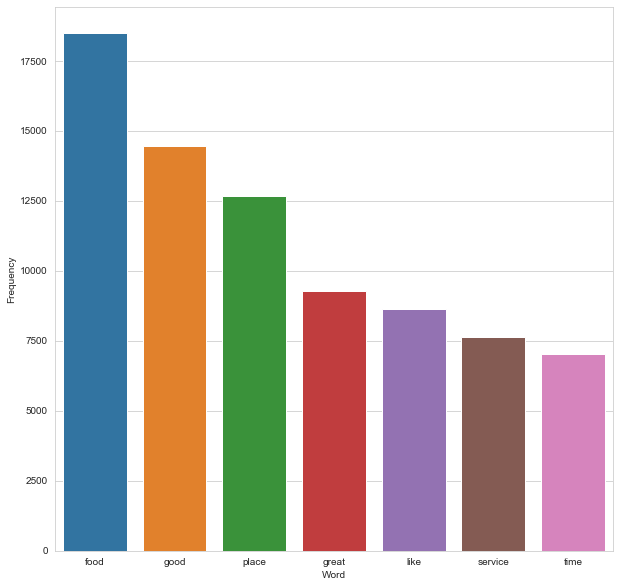

In [58]:
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

In [59]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

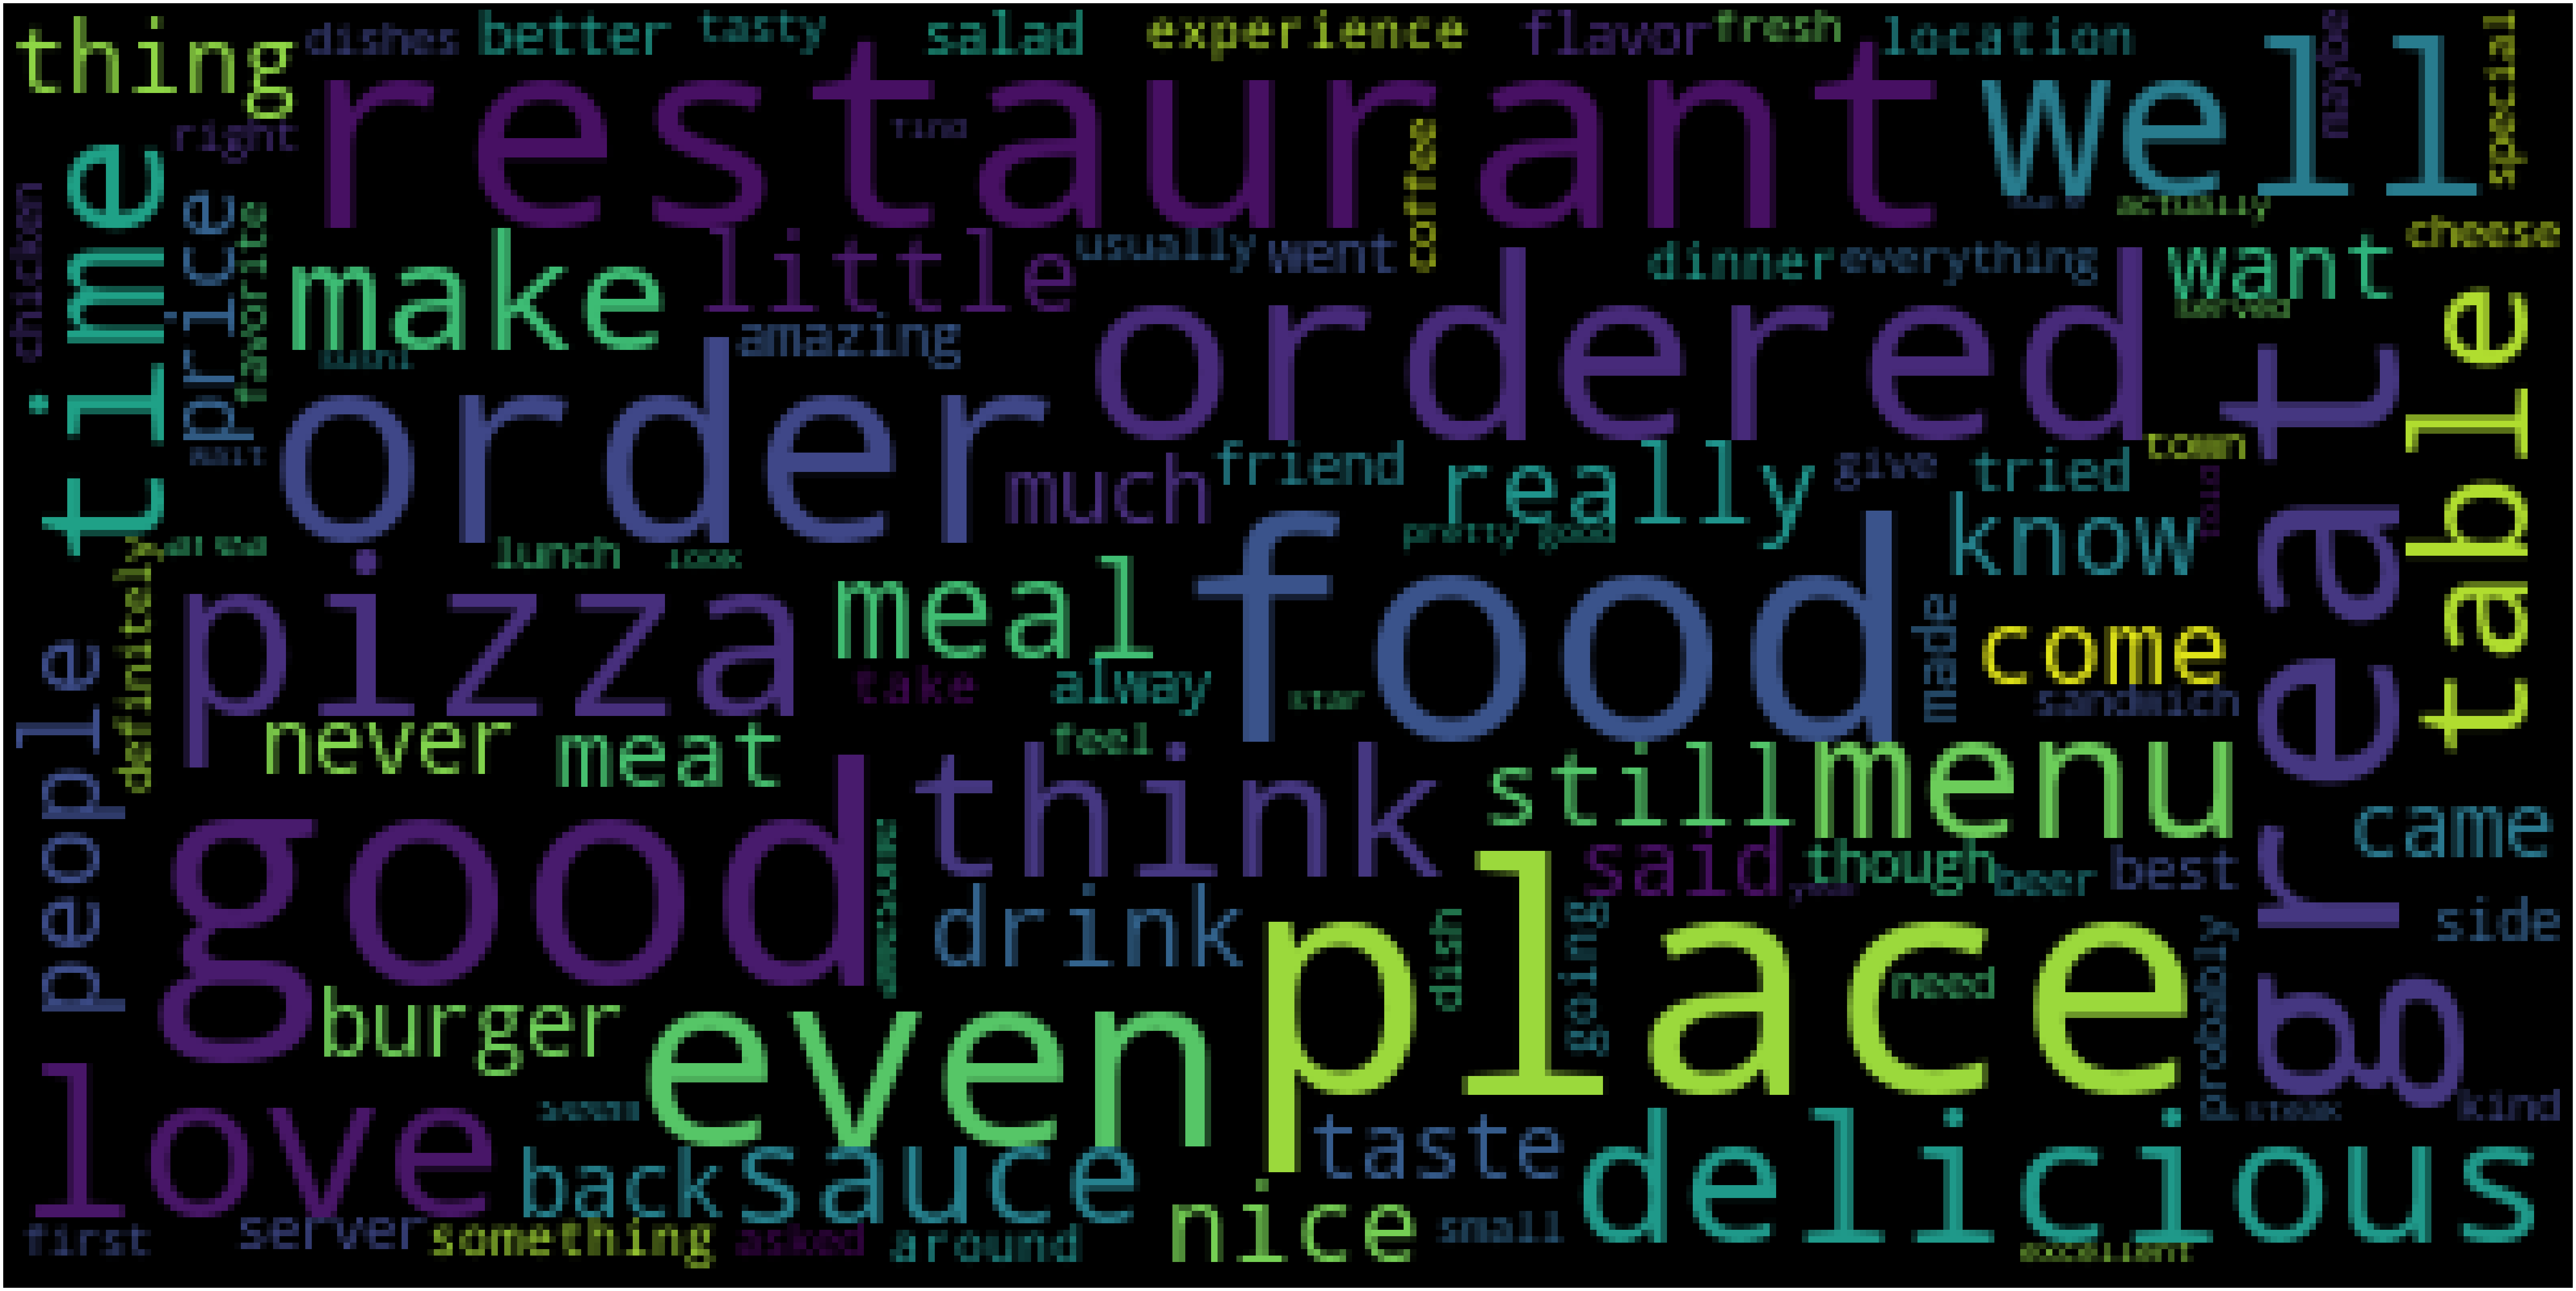

In [60]:
wc(cleaned_data_title,'black','Most Used Words')

In [61]:
from textblob import TextBlob

bloblist_desc = list()

df_review_str=reviews_IL['text'].astype(str)

In [62]:
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

In [63]:
df_polarity_desc.head()

,Review,sentiment,polarity
0,Everything was pretty good but the beef in the...,0.310795,0.591818
1,Very pleased with everything I've bought here:...,0.483333,0.683333
2,Nothing like paying $10+ for a container of cu...,0.500000,0.500000
3,Modified my previous review after the store ow...,0.185498,0.512874
4,The service is terrible. \n\nWe had a huge gro...,-0.154545,0.480952


In [65]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] == 0:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

In [66]:
df_polarity_desc['Sentiment_Type'] =df_polarity_desc.apply(f,axis=1)

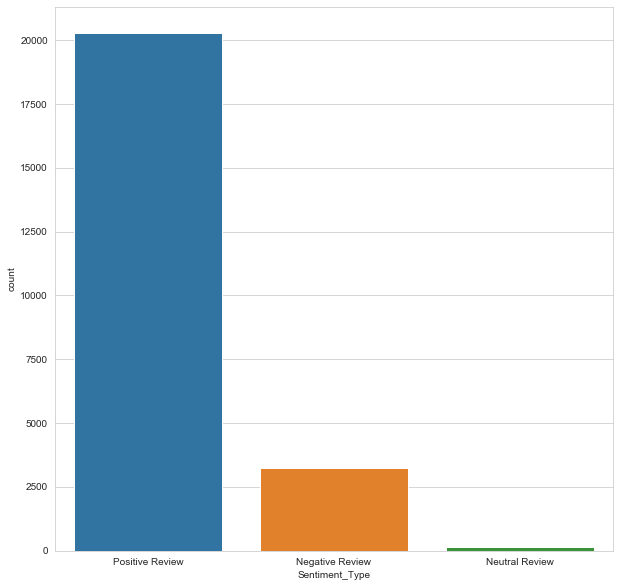

In [67]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

In [68]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']

In [69]:
negative_reviews.head()

,Review,sentiment,polarity,Sentiment_Type
4,The service is terrible. \n\nWe had a huge gro...,-0.154545,0.480952,Negative Review
6,I would have given this restaurant zero stars ...,-0.206667,0.540000,Negative Review
16,So...no. Just...no. Before I picked up a plate...,-0.023377,0.420491,Negative Review
17,Having been to many other tgifridays I can say...,-0.189000,0.639000,Negative Review
25,Poor Chorizo super burrito. The Chorizo was b...,-0.033333,0.633333,Negative Review
